In [56]:
from ib_insync import *
import pandas as pd
from datetime import datetime, timedelta
import requests
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


In [57]:
util.startLoop()

In [58]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

In [59]:
# Definir el contrato para la acción de Citigroup Inc (C)
contract = Stock('C', 'SMART', 'USD')

In [61]:
# Establecer el rango de tiempo
end_time = datetime.now()
start_time = end_time - timedelta(days=30)

In [62]:
# Obtener datos históricos
bars = ib.reqHistoricalData(
    contract,
    endDateTime=end_time,
    durationStr='30 D',
    barSizeSetting='1 hour',
    whatToShow='TRADES',
    useRTH=False
)

In [65]:
# Convertir los datos a DataFrame
df = util.df(bars)


In [66]:
# Obtener noticias relevantes sobre Citigroup Inc (C)
API_KEY = 'b35c56d955ee45178c703f7f79c1dfca'
news_url = f'https://newsapi.org/v2/everything?q=Citigroup%20OR%20NYSE%20C&apiKey={API_KEY}'
response = requests.get(news_url)
news_data = response.json()


In [67]:
titles = [article['title'] for article in news_data['articles']]
print(f"Titulares de noticias relevantes:\n {titles}")


Titulares de noticias relevantes:
 ['Anker’s new USB-C HDMI cable supports 140W fast charging', 'Toyota introduces an electric C-HR and updated bZ4X for Europe', 'Apple iPhone 16e (2025): Specs, Price, Release Date', 'San Francisco Is Getting Its Own Council of Tech Oligarchs', 'HP Docking Station Just Got 45% Cheaper, Combine All Your Cords Into Just One', 'This Tiny USB-C Charger From Anker Packs a Punch and It’s Almost 50% Off', 'EA open-sources four more Command & Conquer games', 'Verge staffers react to the iPhone 16E: what we love and don’t love', 'The Nintendo Switch 2 will have NFC and Wi-Fi 6, FCC filings show', 'EA Releases Source Code For Old Command and Conquer Games', 'Anker SOLIX C200 Power Bank Station Drops Below $100, and It’s Just a Bit Larger Than an iPhone 16 Pro Max', 'C+P: Combining the Usefulness of C with the Excellence of Prolog', 'Amazon Alexa event live blog: all the news from the keynote', "Pick up one of our favorite power banks while it's on sale for 52 pe

In [68]:
# Análisis de sentimiento de noticias
positive_keywords = ['rise', 'growth', 'record', 'profit']
negative_keywords = ['fall', 'loss', 'decline', 'drop']

In [69]:
positive_news = sum(1 for title in titles if any(word in title.lower() for word in positive_keywords))
negative_news = sum(1 for title in titles if any(word in title.lower() for word in negative_keywords))
impact_factor = 1 + (positive_news - negative_news) * 0.001

In [70]:
# Seleccionar datos y normalizar
data = df[['open', 'high', 'low', 'close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data_adjusted = scaled_data * impact_factor

In [71]:
# Identificar soportes y resistencias
def find_support_resistance(data):
    levels = []
    for i in range(2, len(data) - 2):
        if data[i] < data[i - 1] and data[i] < data[i + 1]:
            levels.append((i, data[i]))  # Soporte
        elif data[i] > data[i - 1] and data[i] > data[i + 1]:
            levels.append((i, data[i]))  # Resistencia
    return levels

support_resistance_levels = find_support_resistance(df['close'].values)
print(f"Niveles de soporte y resistencia detectados: {support_resistance_levels}")


Niveles de soporte y resistencia detectados: [(2, np.float64(78.5)), (4, np.float64(78.86)), (5, np.float64(78.45)), (7, np.float64(78.59)), (8, np.float64(78.54)), (12, np.float64(79.61)), (14, np.float64(79.46)), (19, np.float64(79.88)), (20, np.float64(79.85)), (24, np.float64(81.95)), (25, np.float64(81.57)), (27, np.float64(82.32)), (28, np.float64(82.23)), (30, np.float64(82.48)), (31, np.float64(82.37)), (35, np.float64(82.7)), (36, np.float64(82.55)), (37, np.float64(82.63)), (38, np.float64(81.72)), (40, np.float64(82.31)), (41, np.float64(81.73)), (42, np.float64(81.76)), (43, np.float64(81.7)), (47, np.float64(81.68)), (48, np.float64(82.03)), (49, np.float64(81.91)), (52, np.float64(82.04)), (55, np.float64(80.41)), (57, np.float64(80.74)), (58, np.float64(80.63)), (61, np.float64(80.75)), (62, np.float64(80.71)), (63, np.float64(80.73)), (64, np.float64(80.59)), (68, np.float64(80.39)), (69, np.float64(80.93)), (70, np.float64(80.73)), (74, np.float64(81.42)), (75, np.floa

In [72]:
# Crear secuencias de datos para LSTM
sequence_length = 60
x_train, y_train = [], []
for i in range(sequence_length, len(scaled_data_adjusted)):
    x_train.append(scaled_data_adjusted[i-sequence_length:i])
    y_train.append(scaled_data_adjusted[i])

x_train, y_train = np.array(x_train), np.array(y_train)

In [73]:
# Definir modelo LSTM
model = Sequential()
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=4))

# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2211
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0485
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0231
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0183
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0152
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0149
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0112
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0119
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0134
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0116
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0115
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0109
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0095
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0099
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0094
Epoc

In [74]:
# Predicciones
recent_data = scaled_data_adjusted[-sequence_length:]
predictions = []
for _ in range(10):
    x_input = np.array([recent_data])
    predicted_price = model.predict(x_input)
    predictions.append(predicted_price[0])
    recent_data = np.append(recent_data[1:], [predicted_price[0]], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [75]:
# Desnormalizar predicciones
predictions = scaler.inverse_transform(predictions)
prediction_times = [end_time.replace(hour=12, minute=0, second=0) + timedelta(hours=i) for i in range(1, 11)]
predicted_df = pd.DataFrame(predictions, columns=['open', 'high', 'low', 'close'], index=prediction_times)
print(predicted_df)


                                 open       high        low      close
2025-03-19 13:00:00.931779  70.273764  70.722814  70.015670  70.064350
2025-03-19 14:00:00.931779  70.306476  70.756855  70.047668  70.097121
2025-03-19 15:00:00.931779  70.307136  70.755718  70.049855  70.102416
2025-03-19 16:00:00.931779  70.285595  70.731737  70.031754  70.088063
2025-03-19 17:00:00.931779  70.249026  70.693189  69.999874  70.059973
2025-03-19 18:00:00.931779  70.202569  70.645541  69.958763  70.022482
2025-03-19 19:00:00.931779  70.149861  70.592364  69.911622  69.978733
2025-03-19 20:00:00.931779  70.093445  70.535980  69.860710  69.930988
2025-03-19 21:00:00.931779  70.035081  70.477900  69.807631  69.880862
2025-03-19 22:00:00.931779  69.975968  70.419114  69.753500  69.829499


In [41]:
import matplotlib.pyplot as plt

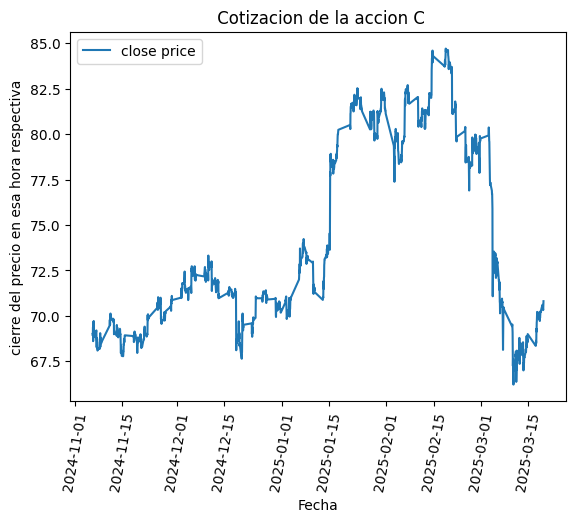

In [42]:
plt.Figure(figsize=(10, 8))
plt.plot(df['date'], df['close'], label='close price')


#Le ponemos titulos al mapa que tenemos
plt.title(' Cotizacion de la accion C')
plt.xlabel('Fecha')
plt.ylabel('cierre del precio en esa hora respectiva')
plt.xticks(rotation = 80)
plt.legend()

plt.show()

In [55]:
ib.disconnect()